In [1]:
import numpy as np
import os
import wget
from sklearn.model_selection import train_test_split
import tensorflow as tf
from training_utils import download_file, get_batches, read_and_decode_single_example, load_validation_data, \
    download_data, evaluate_model, get_training_data, load_weights, flatten, _scale_input_data, augment, _conv2d_batch_norm, standardize
import argparse
from tensorboard import summary as summary_lib

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## ARGUMENTS
epochs = 1
dataset = 10
init_model = None
restore_model = None
how = "normal"
action = "eval"
threshold = 0.5
freeze = False
stop = False
contrast = 1
normalize = False
weight = 7.0
distort = False
version = 1

In [3]:
# figure out how to label the model name
if how == "label":
    model_label = "l"
elif how == "normal":
    model_label = "b"
else:
    model_label = "x"

# precalculated pixel mean of images
mu = 104.1353

# download the data
download_data(what=dataset)

## config
batch_size = 32

train_files, total_records = get_training_data(what=dataset)

In [4]:
## Hyperparameters
epsilon = 1e-8

# learning rate
epochs_per_decay = 5
decay_factor = 0.80
staircase = True

# if we are retraining some layers start with smaller learning rate
if not stop and not freeze:
    starting_rate = 0.001
else:
    starting_rate = 0.0001

# learning rate decay variables
steps_per_epoch = int(total_records / batch_size)
print("Steps per epoch:", steps_per_epoch)

# lambdas
lamC = 0.00001
lamF = 0.00250

# use dropout
dropout = True
fcdropout_rate = 0.5
convdropout_rate = 0.001
pooldropout_rate = 0.1

if how == "label":
    num_classes = 5
elif how == "normal":
    num_classes = 2
elif how == "mass":
    num_classes = 3
elif how == "benign":
    num_classes = 3

print("Number of classes:", num_classes)

Steps per epoch: 1746
Number of classes: 2


In [5]:
## Build the graph
graph = tf.Graph()

model_name = "model_s2.0.0.36" + model_label + "." + str(dataset) + str(version)
## Change Log
# 0.0.0.4 - increase pool3 to 3x3 with stride 3
# 0.0.0.6 - reduce pool 3 stride back to 2
# 0.0.0.7 - reduce lambda for l2 reg
# 0.0.0.8 - increase conv1 to 7x7 stride 2
# 0.0.0.9 - disable per image normalization
# 0.0.0.10 - commented out batch norm in conv layers, added conv4 and changed stride of convs to 1, increased FC lambda
# 0.0.0.11 - turn dropout for conv layers on
# 0.0.0.12 - added batch norm after pooling layers, increase pool dropout, decrease conv dropout, added extra conv layer to reduce data dimensionality
# 0.0.0.13 - added precision and f1 summaries
# 0.0.0.14 - fixing batch normalization, I don't think it's going to work after each pool
# 0.0.0.15 - reduced xentropy weighting term
# 0.0.0.17 - replaced initial 5x5 conv layers with 3 3x3 layers
# 0.0.0.18 - changed stride of first conv to 2 from 1
# 0.0.0.19 - doubled units in two fc layers
# 0.0.0.20 - lowered learning rate, put a batch norm back in
# 0.0.0.21 - put all batch norms back in
# 0.0.0.22 - increased lambdaC, removed dropout from conv layers
# 1.0.0.23 - added extra conv layers
# 1.0.0.27 - updates to training code and metrics
# 1.0.0.28 - using weighted x-entropy to improve recall
# 1.0.0.29 - updated code to work training to classify for multiple classes
# 1.0.0.29f - putting weighted x-entropy back
# 1.0.0.30b - changed some hyperparameters
# 1.0.0.31l - added decision threshold to predictions
# 1.0.0.33 - scaling input data
# 1.0.0.34 - centering data by 127, not by mean
# 1.0.0.35 - not centering data, just scaling it
# 2.0.0.35 - turning into fcn
# 2.0.0.36 - scaling and centering data?

with graph.as_default():
    training = tf.placeholder(dtype=tf.bool, name="is_training")
    is_testing = tf.placeholder(dtype=bool, shape=(), name="is_testing")

    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(starting_rate,
                                               global_step,
                                               steps_per_epoch * epochs_per_decay,
                                               decay_factor,
                                               staircase=staircase)

    with tf.name_scope('inputs') as scope:
        image, label = read_and_decode_single_example(train_files, label_type=how, normalize=False, distort=False)

        X_def, y_def = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=2000,
                                              seed=None,
                                              min_after_dequeue=1000)

        # Placeholders
        X = tf.placeholder_with_default(X_def, shape=[None, None, None, 1])
        y = tf.placeholder_with_default(y_def, shape=[None])

        # cast to float and scale input data
        X_adj = tf.cast(X, dtype=tf.float32)
        X_adj = _scale_input_data(X_adj, contrast=contrast, mu=127.0, scale=255.0)

        # optional online data augmentation
        if distort:
            X_adj, y = augment(X_adj, y, horizontal_flip=True, vertical_flip=True, mixup=0)

    # Convolutional layer 1
    with tf.name_scope('conv1') as scope:
        conv1 = tf.layers.conv2d(
            X_adj,  # Input data
            filters=32,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=100),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1'
        )

        conv1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        conv1_bn_relu = tf.nn.relu(conv1, name='relu1')

    with tf.name_scope('conv1.1') as scope:
        conv11 = tf.layers.conv2d(
            conv1_bn_relu,  # Input data
            filters=32,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 2
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=101),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1.1'
        )

        conv11 = tf.layers.batch_normalization(
            conv11,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1.1'
        )

        # apply relu
        conv11 = tf.nn.relu(conv11, name='relu1.1')


    with tf.name_scope('conv1.2') as scope:
        conv12 = tf.layers.conv2d(
            conv11,  # Input data
            filters=32,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 2
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1101),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1.2'
        )

        conv12 = tf.layers.batch_normalization(
            conv12,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1.2'
        )

        # apply relu
        conv12 = tf.nn.relu(conv12, name='relu1.1')

    # Max pooling layer 1
    with tf.name_scope('pool1') as scope:
        pool1 = tf.layers.max_pooling2d(
            conv12,  # Input
            pool_size=(3, 3),  # Pool size: 3x3
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            name='pool1'
        )

        # optional dropout
        if dropout:
            pool1 = tf.layers.dropout(pool1, rate=pooldropout_rate, seed=103, training=training)

    # Convolutional layer 2
    with tf.name_scope('conv2.1') as scope:
        conv2 = tf.layers.conv2d(
            pool1,  # Input data
            filters=64,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 9x9
            strides=(1, 1),  # Stride: 1
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=104),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2.1'
        )

        conv2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2.1'
        )

        # apply relu
        conv2 = tf.nn.relu(conv2, name='relu2.1')

    # Convolutional layer 2
    with tf.name_scope('conv2.2') as scope:
        conv22 = tf.layers.conv2d(
            conv2,  # Input data
            filters=64,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 9x9
            strides=(1, 1),  # Stride: 1
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1104),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2.2'
        )

        conv22 = tf.layers.batch_normalization(
            conv22,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2.2'
        )

        # apply relu
        conv22 = tf.nn.relu(conv22, name='relu2.2')

    # Max pooling layer 2
    with tf.name_scope('pool2') as scope:
        pool2 = tf.layers.max_pooling2d(
            conv22,  # Input
            pool_size=(2, 2),  # Pool size: 3x3
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            name='pool2'
        )

        # optional dropout
        if dropout:
            pool2 = tf.layers.dropout(pool2, rate=pooldropout_rate, seed=106, training=training)

    # Convolutional layer 3
    with tf.name_scope('conv3.1') as scope:
        conv3 = tf.layers.conv2d(
            pool2,  # Input data
            filters=128,  # 48 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 1
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=107),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3.1'
        )

        conv3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3.1'
        )

        # apply relu
        conv3 = tf.nn.relu(conv3, name='relu3.1')

    # Convolutional layer 3
    with tf.name_scope('conv3.2') as scope:
        conv32 = tf.layers.conv2d(
            conv3,  # Input data
            filters=128,  # 48 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 1
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1107),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3.2'
        )

        conv32 = tf.layers.batch_normalization(
            conv32,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3.2'
        )

        # apply relu
        conv32 = tf.nn.relu(conv32, name='relu3.2')

    # Max pooling layer 3
    with tf.name_scope('pool3') as scope:
        pool3 = tf.layers.max_pooling2d(
            conv32,  # Input
            pool_size=(2, 2),  # Pool size: 2x2
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            name='pool3'
        )

        if dropout:
            pool3 = tf.layers.dropout(pool3, rate=pooldropout_rate, seed=109, training=training)

    # Convolutional layer 4
    with tf.name_scope('conv4') as scope:
            conv4 = tf.layers.conv2d(
                pool3,  # Input data
                filters=256,  # 48 filters
                kernel_size=(3, 3),  # Kernel size: 5x5
                strides=(1, 1),  # Stride: 1
                padding='SAME',  # "same" padding
                activation=None,  # None
                kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=110),
                kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
                name='conv4'
            )

            conv4 = tf.layers.batch_normalization(
                conv4,
                axis=-1,
                momentum=0.99,
                epsilon=epsilon,
                center=True,
                scale=True,
                beta_initializer=tf.zeros_initializer(),
                gamma_initializer=tf.ones_initializer(),
                moving_mean_initializer=tf.zeros_initializer(),
                moving_variance_initializer=tf.ones_initializer(),
                training=training,
                name='bn4'
            )

            # apply relu
            conv4_bn_relu = tf.nn.relu(conv4, name='relu4')

            #if dropout:
            #    conv4_bn_relu = tf.layers.dropout(conv4_bn_relu, rate=convdropout_rate, seed=111, training=training)

    # Max pooling layer 4
    with tf.name_scope('pool4') as scope:
            pool4 = tf.layers.max_pooling2d(
                conv4_bn_relu,  # Input
                pool_size=(2, 2),  # Pool size: 2x2
                strides=(2, 2),  # Stride: 2
                padding='SAME',  # "same" padding
                name='pool4'
            )

            if dropout:
                pool4 = tf.layers.dropout(pool4, rate=pooldropout_rate, seed=112, training=training)

            # Convolutional layer 4
    with tf.name_scope('conv5') as scope:
        conv5 = tf.layers.conv2d(
            pool4,  # Input data
            filters=512,  # 48 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 1
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=113),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv5'
        )

        conv5 = tf.layers.batch_normalization(
            conv5,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn5'
        )

        # apply relu
        conv5_bn_relu = tf.nn.relu(conv5, name='relu5')

    # Max pooling layer 4
    with tf.name_scope('pool5') as scope:
        pool5 = tf.layers.max_pooling2d(
            conv5_bn_relu,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME',
            name='pool5'
        )

        if dropout:
            pool5 = tf.layers.dropout(pool5, rate=pooldropout_rate, seed=115, training=training)

    if stop:
        pool5 = tf.stop_gradient(pool5, name="pool5_freeze")

    fc1 = _conv2d_batch_norm(pool5, 2048, kernel_size=(5, 5), stride=(5, 5), training=training, epsilon=1e-8,
                             padding="VALID", seed=1013, lambd=lamC, name="fc_1")

    fc2 = _conv2d_batch_norm(fc1, 2048, kernel_size=(1, 1), stride=(1, 1), training=training, epsilon=1e-8,
                             padding="VALID", seed=1014, lambd=lamC, name="fc_2")

    fc3 = tf.layers.dense(
        fc2,
        num_classes,  # One output unit per category
        activation=None,  # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=121),
        bias_initializer=tf.zeros_initializer(),
        name="fc_logits"
    )

    logits = tf.squeeze(fc3, name="fc_flat_logits")

    # get the fully connected variables so we can only train them when retraining the network
    fc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "fc")

    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
        kernel_transposed = tf.transpose(conv_kernels1, [3, 0, 1, 2])

    with tf.variable_scope('visualization'):
        tf.summary.image('conv1/filters', kernel_transposed, max_outputs=32, collections=["kernels"])

    ## Loss function options
    # Regular mean cross entropy
    #mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    # Different weighting method
    # This will weight the positive examples higher so as to improve recall
    weights = tf.multiply(weight, tf.cast(tf.greater(y, 0), tf.float32)) + 1
    mean_ce = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits, weights=weights))

    # Add in l2 loss
    loss = mean_ce + tf.losses.get_regularization_loss()

    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    # Minimize cross-entropy - freeze certain layers depending on input
    if freeze:
        train_op = optimizer.minimize(loss, global_step=global_step, var_list=fc_vars)
    else:
        train_op = optimizer.minimize(loss, global_step=global_step)

    # get the probabilites for the classes
    probabilities = tf.nn.softmax(logits, name="probabilities")
    abnormal_probability = 1 - probabilities[:,0]

    # Compute predictions from the probabilities
    if threshold == 0.5:
        predictions = tf.argmax(probabilities, axis=1, output_type=tf.int32)
    else:
        predictions = tf.cast(tf.greater(abnormal_probability, threshold), tf.int32)

    # get the accuracy
    accuracy, acc_op = tf.metrics.accuracy(
        labels=y,
        predictions=predictions,
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        name="accuracy",
    )

    # calculate recall
    if num_classes > 2:
        # collapse the predictions down to normal or not for our pr metrics
        zero = tf.constant(0, dtype=tf.int64)
        collapsed_predictions = tf.cast(tf.greater(abnormal_probability, threshold), tf.int32)
        collapsed_labels = tf.greater(y, 0)

        recall, rec_op = tf.metrics.recall(labels=collapsed_labels, predictions=collapsed_predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="recall")
        precision, prec_op = tf.metrics.precision(labels=collapsed_labels, predictions=collapsed_predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="precision")

    else:
        recall, rec_op = tf.metrics.recall(labels=y, predictions=predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="recall")
        precision, prec_op = tf.metrics.precision(labels=y, predictions=predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="precision")

    f1_score = 2 * ((precision * recall) / (precision + recall))
    _, update_op = summary_lib.pr_curve_streaming_op(name='pr_curve',
                                                     predictions=abnormal_probability,
                                                     labels=y,
                                                     updates_collections=tf.GraphKeys.UPDATE_OPS,
                                                     num_thresholds=20)

    tf.summary.scalar('recall_1', recall, collections=["summaries"])
    tf.summary.scalar('precision_1', precision, collections=["summaries"])
    tf.summary.scalar('f1_score', f1_score, collections=["summaries"])

    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy, collections=["summaries"])
    tf.summary.scalar('cross_entropy', mean_ce, collections=["summaries"])
    tf.summary.scalar('learning_rate', learning_rate, collections=["summaries"])

    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    # Merge all the summaries
    merged = tf.summary.merge_all("summaries")
    kernel_summaries = tf.summary.merge_all("kernels")
    per_epoch_summaries = [[]]

    print("Graph created...")

Instructions for updating:
Use the retry module or similar alternatives.
Graph created...


In [6]:
## CONFIGURE OPTIONS
if init_model is not None:
    if os.path.exists(os.path.join("model", init_model + '.ckpt.index')):
        init = False
    else:
        init = True
elif restore_model is not None:
    if os.path.exists(os.path.join("model", restore_model + '.ckpt.index')):
        init = False
    else:
        init = True
else:
    if os.path.exists(os.path.join("model", model_name + '.ckpt.index')):
        init = False
    else:
        init = True

meta_data_every = 1
log_to_tensorboard = True
print_every = 5  # how often to print metrics
checkpoint_every = 1  # how often to save model in epochs
use_gpu = False  # whether or not to use the GPU
print_metrics = True  # whether to print or plot metrics, if False a plot will be created and updated every epoch

# Initialize metrics or load them from disk if they exist
if os.path.exists(os.path.join("data", model_name + "train_acc.npy")):
    train_acc_values = np.load(os.path.join("data", model_name + "train_acc.npy")).tolist()
else:
    train_acc_values = []

if os.path.exists(os.path.join("data", model_name + "train_loss.npy")):
    train_cost_values = np.load(os.path.join("data", model_name + "train_loss.npy")).tolist()
else:
    train_cost_values = []

if os.path.exists(os.path.join("data", model_name + "train_lr.npy")):
    train_lr_values = np.load(os.path.join("data", model_name + "train_lr.npy")).tolist()
else:
    train_lr_values = []

if os.path.exists(os.path.join("data", model_name + "train_recall.npy")):
    train_recall_values = np.load(os.path.join("data", model_name + "train_recall.npy")).tolist()
else:
    train_recall_values = []

if os.path.exists(os.path.join("data", model_name + "cv_acc.npy")):
    valid_acc_values = np.load(os.path.join("data", model_name + "cv_acc.npy")).tolist()
else:
    valid_acc_values = []

if os.path.exists(os.path.join("data", model_name + "cv_loss.npy")):
    valid_cost_values = np.load(os.path.join("data", model_name + "cv_loss.npy")).tolist()
else:
    valid_cost_values = []

if os.path.exists(os.path.join("data", model_name + "cv_recall.npy")):
    valid_recall_values = np.load(os.path.join("data", model_name + "cv_recall.npy")).tolist()
else:
    valid_recall_values = []

config = tf.ConfigProto(device_count = {'GPU': 0})
# config = tf.ConfigProto()

In [9]:
config = tf.ConfigProto()
with tf.Session(graph=graph, config=config) as sess:
    # create the saver
    saver = tf.train.Saver()
    
    saver.restore(sess, './model/' + model_name + '.ckpt')
    print("Restoring model", model_name)
            
    sess.run(tf.local_variables_initializer())
    print("Evaluating on test data")
    
    #######################################################################################
    ## evaluate on the test data
    X_te, y_te = load_validation_data(how=how, data="test", which=dataset)

    test_accuracy = []
    test_recall = []
    test_predictions = []
    ground_truth = []
    for X_batch, y_batch in get_batches(X_te, y_te, batch_size, distort=False):
        _, yhat, test_acc_value, test_recall_value = sess.run([extra_update_ops, predictions, accuracy, rec_op], feed_dict=
        {
            X: X_batch,
            y: y_batch,
            training: False
        })

        test_accuracy.append(test_acc_value)
        test_recall.append(test_recall_value)
        test_predictions.append(yhat)
        ground_truth.append(y_batch)
        
    accuracy_value, recall_value = sess.run([accuracy, recall], feed_dict=
        {
            X: X_te[0:1],
            y: y_te[0:1],
            training: False
        })
        
    print("Accuracy:", accuracy_value)
    print("Recall:", recall_value)
        
    # print the results
    print("Mean Test Accuracy:", np.mean(test_accuracy))
    print("Mean Test Recall:", np.mean(test_recall))

    sess.run(tf.local_variables_initializer())
    
    ########################################################################################
    ## Evaluate on MIAS Data
    print()
    print("Evaluating on MIAS data")

    ## evaluate on MIAS  dataset 9 which is the closest to raw images we have
    X_te, y_te = load_validation_data(how=how, data="mias", which=9)

    mias_test_accuracy = []
    mias_test_recall = []
    mias_test_predictions = []
    mias_ground_truth = []
    for X_batch, y_batch in get_batches(X_te, y_te, batch_size, distort=False):
        _, yhat, test_acc_value, test_recall_value = sess.run([extra_update_ops, predictions, accuracy, rec_op], feed_dict=
        {
            X: X_batch,
            y: y_batch,
            training: False
        })

        mias_test_accuracy.append(test_acc_value)
        mias_test_recall.append(test_recall_value)
        mias_test_predictions.append(yhat)
        mias_ground_truth.append(y_batch)

    # print the results
    print("Mean MIAS Accuracy:", np.mean(mias_test_accuracy))
    print("Mean MIAS Recall:", np.mean(mias_test_recall))

INFO:tensorflow:Restoring parameters from ./model/model_s2.0.0.36b.101.ckpt
Restoring model model_s2.0.0.36b.101
Evaluating on test data
Accuracy: 0.9520958
Recall: 0.96007985
Mean Test Accuracy: 0.94831157
Mean Test Recall: 0.9515739

Evaluating on MIAS data
Mean MIAS Accuracy: 0.69985956
Mean MIAS Recall: 0.9222879


## Evaluate on Whole Images

In [ ]:
import PIL
from PIL import ImageMath
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

def trim_edges_from_image(image):
    # trim from the left side
    h = image.shape[0]
    
    # figure if a column contains almost all black pixels
    black_cols = np.sum(image <= 9, axis=0) == h
    
    return image[:,~black_cols]

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Rows are scores for each class. 
    Columns are predictions (samples).
    """
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

def scale_data(input_data, new_min=0.0, new_max=255.0):
    old_max = np.max(input_data)
    old_min = np.min(input_data)
    
    adjustment_factor = (new_max - new_min) / (old_max - old_min)
    scaled_data = adjustment_factor * (input_data - old_min) + new_min
    
    return scaled_data

def summarize(data):
    print("Mean:", np.mean(data))
    print("Min:", np.min(data))
    print("Max:", np.max(data))
    print("Std:", np.std(data))
    
def resize_image(image, factor):
    h = image.shape[0]
    w = image.shape[1]
    
    new_size = (int(h * factor), int(w * factor))
    
    image = imresize(image, new_size)
    
    return image

def load_image(image, mask=None, scale=0.5, trim=True, margin=0.15, contrast=1.0, normalize=False, base_path= "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\"):
    image_path = os.path.join(base_path, image)
    image = PIL.Image.open(image_path)
   
    # if the image is a png convert it to RGB 
    if ".png" in image_path:
        image = ImageMath.eval('im/256', {'im':image}).convert('L')
        
    image = np.array(image)

    # try to lose the extra channels, if there is an error they don't exist
    try:
        image = image[:,:,0]
    except:
        pass
    
    h = image.shape[0]
    w = image.shape[1]
    
    new_h = int(h * scale)
    new_w = int(w * scale)
    
    if mask is not None:
        mask_path = base_path + mask
        mask = PIL.Image.open(mask_path)
        mask = np.array(mask)
        mask = mask[:,:,0]
        mask = imresize(mask, (new_h, new_w))
   
    image = imresize(image, (new_h, new_w))
    
    if margin != 0:
        h = image.shape[0]
        w = image.shape[1]

        # trim margin off each side
        h_border = int(h * margin)
        w_border = int(w * margin)

        image = image[h_border:(h-h_border),w_border:(w-w_border)]
    
    if trim:
        image = trim_edges_from_image(image)
    
    if contrast != 1.0:
        mu = np.mean(image)
        image = (image - mu) * contrast + mu
    
    if normalize:
        image = scale_data(image)
    
    return image, mask

def load_images(dir_name, base_path= "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\"):
    directory = base_path + dir_name + "\\"
    files = os.listdir(directory)
    
    images = []
    
    for file in files:
        image, _ = load_image(file, base_path = directory)
        images.append(image)
        
    return images

In [ ]:
## Predictions for directory of images
# directory = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\ddsm\\Lumisys pngs"
directory = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\MIAS"
files = os.listdir(directory)[:50]

scale = 2.5
# scale = 0.5
how = "normal"
dataset = 10
model_name = "model_s2.0.0.36b.101"

config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.7

# config = tf.ConfigProto(device_count = {"GPU": 0, "CPU": 1})

## Evaluate on test data multi-class
with tf.Session(graph=graph, config=config) as sess:
    # create the saver
    saver = tf.train.Saver()
    
    # restore the model
    sess.run(tf.local_variables_initializer())
    saver.restore(sess, './model/' + model_name + '.ckpt')
    
    max_probs = []
    all_probs = []
    count = 0
    i = 0
    for file in files:
        i += 1
        image, _ = load_image(file, base_path=directory, margin=0.15, contrast=0.5, scale=scale, normalize=False)
        
        # reshape the input so tensorflow can handle it
        image = image.reshape(1,image.shape[0], image.shape[1], 1)

        yhat = sess.run(probabilities, feed_dict = {
            X: image,
            training: False,
            })
        
        try:
            abnormal_probs = yhat[:,:,1]
        except:
            abnormal_probs = yhat[:,1]
            
        all_probs.append(abnormal_probs)
        max_prob = np.max(abnormal_probs)
        max_probs.append(max_prob)
        print(i, "Image:", file, " - Shape:", image.shape, "- Probability:", max_prob)
        
        if max_prob > 0.75:
            count += 1
            
print("Positive Predictions:", count, "out of", len(files))
print("Mean Max Prob:", np.mean(max_probs))        
print("Min Max Prob:", np.min(max_probs))        
print("Max Max Prob:", np.max(max_probs))   

INFO:tensorflow:Restoring parameters from ./model/model_s2.0.0.36b.101.ckpt


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1 Image: mdb001.jpg  - Shape: (1, 1792, 1137, 1) - Probability: 0.7569414
2 Image: mdb002.jpg  - Shape: (1, 1792, 1453, 1) - Probability: 0.819119
3 Image: mdb003.jpg  - Shape: (1, 1792, 1263, 1) - Probability: 0.87800753
4 Image: mdb004.jpg  - Shape: (1, 1792, 1453, 1) - Probability: 0.9986935
5 Image: mdb005.jpg  - Shape: (1, 1792, 1541, 1) - Probability: 0.39502677
6 Image: mdb006.jpg  - Shape: (1, 1792, 1603, 1) - Probability: 0.2246166
7 Image: mdb007.jpg  - Shape: (1, 1792, 1336, 1) - Probability: 0.8798321
8 Image: mdb008.jpg  - Shape: (1, 1792, 1551, 1) - Probability: 0.774896
9 Image: mdb009.jpg  - Shape: (1, 1792, 1334, 1) - Probability: 0.8579751
10 Image: mdb010.jpg  - Shape: (1, 1792, 1158, 1) - Probability: 0.9918208
11 Image: mdb011.jpg  - Shape: (1, 1792, 1527, 1) - Probability: 0.93223006
12 Image: mdb012.jpg  - Shape: (1, 1792, 1495, 1) - Probability: 0.41508433
13 Image: mdb013.jpg  - Shape: (1, 1792, 1273, 1) - Probability: 0.69033766
14 Image: mdb014.jpg  - Shape: 

In [ ]:
all_max_probs = np.array(max_probs)

In [10]:
# reshape the input so tensorflow can handle it
if len(image.shape) != 4:
    image = image.reshape(1,image.shape[0], image.shape[1], 1)

## EVALUATE ON SINGLE IMAGE
with tf.Session(graph=graph, config=config) as sess:
    # create the saver
    saver = tf.train.Saver()
    
    saver.restore(sess, './model/' + model_name + '.ckpt')
    print("Restoring model", model_name)
            
    sess.run(tf.local_variables_initializer())
    
    #######################################################################################
    ## evaluate on the test data
    yhat = sess.run(probabilities, feed_dict=
    {
        X: image,
        training: False
    })
    
try:
    abnormal_probs = yhat[:,:,1]
except:
    abnormal_probs = yhat[1]
    
print("Max Abnormal Prob:", np.max(abnormal_probs))

INFO:tensorflow:Restoring parameters from ./model/model_s2.0.0.36b.101.ckpt
Restoring model model_s2.0.0.36b.101


ValueError: Cannot feed value of shape (2985, 2190) for Tensor 'inputs/PlaceholderWithDefault:0', which has shape '(?, ?, ?, 1)'

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


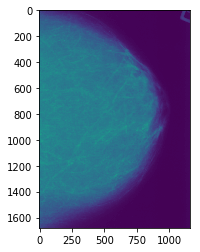

Image: (1680, 1162)


In [8]:
# load an image to classify
# Calc Train Positive Full Image
# image_path = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Calc Train All Full JPEGs\\P_00019_RIGHT_CC_FULL.jpg"

# Mass Train Positive Full Image
# image_path = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Mass Train All JPEGs Full\\P_00064_RIGHT_MLO_FULL.jpg"

# image_path = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Mass Test All Full JPEGs\\P_00032_RIGHT_CC_FULL.jpg"

# negative howtek image
# image_path = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\ddsm\\Howtek pngs\\A_1969_1.LEFT_CC.LJPEG.png"

# negative lumisys
image_path = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\ddsm\\Lumisys pngs\\B_3635_1.LEFT_CC.LJPEG.png"

# negative dba image
# image_path = "E:\\Documents\\Mammography\\DDSM\\PNGs\\DBA pngs\\A_0026_1.LEFT_MLO.LJPEG.png"

# mias image
# image_path = "E:\\Documents\\Mammography\\MIAS\\JPEG\\mdb004.jpg"

# single tile
# image_path = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-images\\1_P_00010_LEFT_CC_2.png"

# open the image
image = PIL.Image.open(image_path)

# convert to numpy array
image = np.array(image)

# try to lose the extra channels, if there is an error they don't exist
try:
    image = image[:,:,0]
except:
    pass

# size it down by half
image = resize_image(image, 0.5)
# image = resize_image(image, 2.58)

h = image.shape[0]
w = image.shape[1]

trim_borders = True
if trim_borders:
    # trim 15% off each side
    h_border = int(h * 0.15)
    w_border = int(w * 0.15)

    image = image[h_border:(h-h_border),w_border:(w-w_border)]

image = trim_edges_from_image(image)    
    
plt.imshow(image)
plt.show()


print("Image:", image.shape)

In [9]:
## Predictions for single image
how = "normal"
dataset = 10
model_name = "model_s2.0.0.36b.101"
# config = tf.ConfigProto(device_count = {'GPU': 0})
config = tf.ConfigProto()

# reshape the input so tensorflow can handle it
if len(image.shape) != 4:
    image = image.reshape(1,image.shape[0], image.shape[1], 1)

print("Image:", image.shape)

## Evaluate on test data multi-class
with tf.Session(graph=graph, config=config) as sess:
    # create the saver
    saver = tf.train.Saver()
    
    saver.restore(sess, './model/' + model_name + '.ckpt')
    print("Restoring model", model_name)
            
    sess.run(tf.local_variables_initializer())
    
    yhat = sess.run(probabilities, feed_dict = {
        X: image,
        training: False,
        })

print("Yhat:", yhat.shape)
try:
    abnormal_probs = yhat[:,:,1]
    print("Max Abnormal Prob:", np.max(abnormal_probs))
except:
    print(yhat)

Image: (1, 1680, 1162, 1)
INFO:tensorflow:Restoring parameters from ./model/model_s2.0.0.36b.101.ckpt
Restoring model model_s2.0.0.36b.101
Yhat: (5, 3, 2)
Max Abnormal Prob: 0.3580893


Positive - R: 0  C: 1 Prob: 0.71646565
Positive - R: 1  C: 0 Prob: 0.5425906
Positive - R: 2  C: 1 Prob: 0.7511966
Positive - R: 2  C: 2 Prob: 0.9994747
Positive - R: 3  C: 0 Prob: 0.9990907
Positive - R: 3  C: 1 Prob: 0.63772833
Positive - R: 4  C: 2 Prob: 0.99791306
Max Prob: 0.9994747


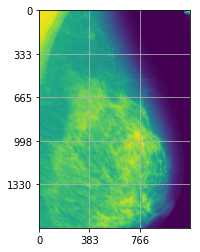

In [9]:
h = yhat.shape[0]
w = yhat.shape[1]
probs = np.zeros_like(yhat)
max_prob = 0

for y in range(h):
    for x in range(w):
        if yhat[y,x,1] > 0.5:
            print("Positive - R:", y, " C:", x, "Prob:", yhat[y,x,1])
        
        if yhat[y,x,1] > max_prob:
            max_prob = yhat[y,x,1]
            
print("Max Prob:", max_prob)

vertlines = image.shape[1] / yhat.shape[0]
horlines = image.shape[2] / yhat.shape[1]

yticks = np.arange(0, image.shape[1], vertlines)
xticks = np.arange(0, image.shape[2], horlines)

plt.imshow(image[0,:,:,0])
plt.grid(True)
plt.yticks(yticks)
plt.xticks(xticks)
plt.show()

In [10]:
np.max(image)

226

In [68]:
import pandas as pd
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df.drop_duplicates(subset=['REFNUM'], keep='first', inplace=True)
actual_abnormal = all_cases_df.CLASS != "NORM"
classes = np.array(actual_abnormal * 1)

max_probs = np.array(max_probs)
preds = max_probs > 0.75
correct = (preds == classes)
tp = (actual_abnormal & preds)

print("TP:",np.sum(tp))
print("Positive Predictions:",np.sum(preds))
print("Accuracy:", np.sum(correct) / len(preds))
print("Recall:",np.sum(tp) / np.sum(actual_abnormal))

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


ValueError: operands could not be broadcast together with shapes (322,) (11,) 

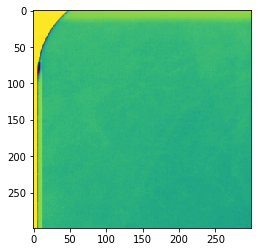

In [14]:
tile = image[0,:299,:299,0]
plt.imshow(tile)

In [19]:
np.mean(tile)

191.22254784622095